<a href="https://colab.research.google.com/github/LucyCVieyra/cats_codes/blob/main/cats_pose_v04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Celda 1

from google.colab import drive
drive.mount('/content/drive')

# dataset
DRIVE_DATASET_ROOT = "/content/drive/MyDrive/cats_dataset"
print("DRIVE_DATASET_ROOT =", DRIVE_DATASET_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DRIVE_DATASET_ROOT = /content/drive/MyDrive/cats_dataset


In [2]:
# Celda 2

import os
import csv
from typing import Tuple
import shutil

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

# copia el dataset de Drive a disco local
LOCAL_DATASET_ROOT = "/content/cats_dataset"

if not os.path.exists(LOCAL_DATASET_ROOT):
    print("Copiando dataset de Drive a disco local (solo se hace una vez)...")
    shutil.copytree(DRIVE_DATASET_ROOT, LOCAL_DATASET_ROOT)
    print("Copia terminada.")
else:
    print("Ya existe copia local en", LOCAL_DATASET_ROOT)

# A partir de aquí se usa la copia local
DATASET_ROOT = LOCAL_DATASET_ROOT
print("DATASET_ROOT =", DATASET_ROOT)

# Ruta al CSV dentro del dataset
CSV_PATH = os.path.join(DATASET_ROOT, "dataset.csv")
print("CSV_PATH:", CSV_PATH)

# Normalización de posición
# Escalas en metros para normalizar x,y,z dentro del Dataset
POS_SCALE = torch.tensor([5.0, 5.0, 3.0], dtype=torch.float32)  # [sx, sy, sz]
print("POS_SCALE (m):", POS_SCALE.tolist())

# Hiperparámetros
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
BETA_ROT = 10.0 # 100.0
IMAGE_SIZE = 224
NUM_WORKERS = 0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", DEVICE)


Ya existe copia local en /content/cats_dataset
DATASET_ROOT = /content/cats_dataset
CSV_PATH: /content/cats_dataset/dataset.csv
POS_SCALE (m): [5.0, 5.0, 3.0]
Usando dispositivo: cuda


In [3]:
# Celda 3

class PoseDataset(Dataset):
    """
    Lee dataset.csv y carga imágenes + vector de pose (x,y,z,q0,q1,q2,q3)
    Filtra por split: 'train', 'val' o 'test'.
    Normaliza posición (x,y,z) dividiendo entre POS_SCALE.
    """
    def __init__(self, csv_path: str, root_dir: str, split: str = "train", transform=None,
                 pos_scale: torch.Tensor = POS_SCALE, normalize_pos: bool = True):
        self.root_dir = root_dir
        self.transform = transform
        self.pos_scale = pos_scale
        self.normalize_pos = normalize_pos
        self.samples = []

        with open(csv_path, "r") as f:
            reader = csv.DictReader(f)
            for row in reader:
                if row["split"] != split:
                    continue

                image_path = row["image_path"]
                full_image_path = os.path.join(root_dir, image_path)

                pose = [
                    float(row["x"]),
                    float(row["y"]),
                    float(row["z"]),
                    float(row["q0"]),
                    float(row["q1"]),
                    float(row["q2"]),
                    float(row["q3"]),
                ]

                self.samples.append((full_image_path, pose))

        if len(self.samples) == 0:
            raise RuntimeError(f"No se encontraron muestras para split={split}. Revisa dataset.csv")

        print(f"Split '{split}': {len(self.samples)} muestras")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img_path, pose = self.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        pose = torch.tensor(pose, dtype=torch.float32)

        # Normalizar solo traslación
        if self.normalize_pos:
            pose[:3] = pose[:3] / self.pos_scale

        return img, pose


# Transforms
# Train: augmentation fotométrico + blur + ruido leve
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),

    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.20, hue=0.05),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.2)),

    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.02 * torch.randn_like(x)),  # ruido
    transforms.Lambda(lambda x: torch.clamp(x, 0.0, 1.0)),

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Val: sin augment
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


Split 'train': 7209 muestras
Split 'val': 2057 muestras
Batch 0 -> images torch.Size([32, 3, 224, 224]), poses torch.Size([32, 7])
Ejemplo pose normalizada [x,y,z,q...]: [-0.3422645926475525, -0.05936681479215622, -0.27305373549461365, -0.9961836338043213, 0.0014830853324383497, 0.001762723783031106, 0.08725260943174362]
Batch 1 -> images torch.Size([32, 3, 224, 224]), poses torch.Size([32, 7])
Ejemplo pose normalizada [x,y,z,q...]: [-1.1077326536178589, 0.30240944027900696, -0.5331458449363708, -0.9339587688446045, 0.002432357519865036, 0.004922534804791212, 0.35733869671821594]
Batch 2 -> images torch.Size([32, 3, 224, 224]), poses torch.Size([32, 7])
Ejemplo pose normalizada [x,y,z,q...]: [-1.1578714847564697, 0.34630221128463745, -0.8682782053947449, -0.9663085341453552, -0.015420353971421719, -0.006095589138567448, 0.2568519115447998]
Sanity check OK, tomó 2.0072085857391357 s
Ejemplo de ruta de imagen: /content/cats_dataset/trayectoria_1/images/image_000000.png


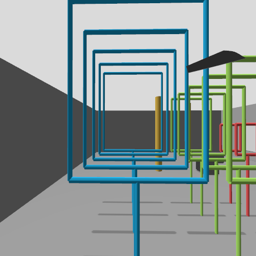

In [4]:
# Celda 4

# Crear datasets
train_dataset = PoseDataset(CSV_PATH, DATASET_ROOT, split="train", transform=train_transform)
val_dataset   = PoseDataset(CSV_PATH, DATASET_ROOT, split="val",   transform=val_transform)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

# Sanity check
import time

start = time.time()
for i, (images, poses) in enumerate(train_loader):
    print(f"Batch {i} -> images {images.shape}, poses {poses.shape}")
    print("Ejemplo pose normalizada [x,y,z,q...]:", poses[0].tolist())
    if i == 2:
        break
end = time.time()
print("Sanity check OK, tomó", end - start, "s")

# Ver una imagen
example_path, _ = train_dataset.samples[0]
print("Ejemplo de ruta de imagen:", example_path)

img = Image.open(example_path).convert("RGB")
display(img.resize((256, 256)))


In [5]:
# Celda 5

class PoseNetLight(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        backbone = models.resnet18(weights=weights)

        modules = list(backbone.children())[:-1]
        self.backbone = nn.Sequential(*modules)
        self.backbone_out_dim = backbone.fc.in_features

        self.fc = nn.Sequential(
            nn.Linear(self.backbone_out_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


def pose_loss(pred: torch.Tensor, target: torch.Tensor, beta: float = BETA_ROT) -> torch.Tensor:
    t_pred = pred[:, :3]
    q_pred = pred[:, 3:]
    t_gt   = target[:, :3]
    q_gt   = target[:, 3:]

    # Normalizar cuaternión predicho
    q_pred = q_pred / (torch.norm(q_pred, p=2, dim=1, keepdim=True) + 1e-8)

    t_loss = nn.functional.mse_loss(t_pred, t_gt)
    q_loss = nn.functional.mse_loss(q_pred, q_gt)

    return t_loss + beta * q_loss


model = PoseNetLight(pretrained=True).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

print(model)


PoseNetLight(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [6]:
# Celda 6

import time

def train_one_epoch(model, dataloader, optimizer, device, epoch_idx=0, num_epochs=1):
    model.train()
    running_loss = 0.0
    n_batches = len(dataloader)
    start = time.time()

    for i, (images, poses) in enumerate(dataloader):
        images = images.to(device)
        poses  = poses.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = pose_loss(outputs, poses)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        if (i % 10) == 0:
            elapsed = time.time() - start
            print(f"[Train][Época {epoch_idx}/{num_epochs}] "
                  f"Batch {i}/{n_batches}  Loss batch: {loss.item():.6f}  "
                  f"Tiempo transcurrido: {elapsed:.1f}s")

    epoch_loss = running_loss / len(dataloader.dataset)
    total_time = time.time() - start
    print(f"[Train] Época {epoch_idx} terminada en {total_time:.1f}s  Loss media: {epoch_loss:.6f}")
    return epoch_loss


def eval_one_epoch(model, dataloader, device, epoch_idx=0, num_epochs=1):
    model.eval()
    running_loss = 0.0
    n_batches = len(dataloader)
    start = time.time()

    with torch.no_grad():
        for i, (images, poses) in enumerate(dataloader):
            images = images.to(device)
            poses  = poses.to(device)

            outputs = model(images)
            loss = pose_loss(outputs, poses)
            running_loss += loss.item() * images.size(0)

            if (i % 10) == 0:
                elapsed = time.time() - start
                print(f"[Val][Época {epoch_idx}/{num_epochs}] "
                      f"Batch {i}/{n_batches}  Loss batch: {loss.item():.6f}  "
                      f"Tiempo transcurrido: {elapsed:.1f}s")

    epoch_loss = running_loss / len(dataloader.dataset)
    total_time = time.time() - start
    print(f"[Val] Época {epoch_idx} terminada en {total_time:.1f}s  Loss media: {epoch_loss:.6f}")
    return epoch_loss


In [7]:
# Celda 7

NUM_EPOCHS = 30

best_val_loss = float("inf")
best_model_path = os.path.join(DATASET_ROOT, "posenet_light_best.pth")

for epoch in range(1, NUM_EPOCHS + 1):
    print("=" * 60)
    print(f"Comenzando época {epoch}/{NUM_EPOCHS}")

    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE,
                                 epoch_idx=epoch, num_epochs=NUM_EPOCHS)
    val_loss   = eval_one_epoch(model, val_loader, DEVICE,
                                epoch_idx=epoch, num_epochs=NUM_EPOCHS)

    print(f"Época [{epoch}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
        }, best_model_path)
        print(f"  🟢 Nuevo mejor modelo guardado en: {best_model_path}")

print("Entrenamiento terminado. Mejor val_loss:", best_val_loss)


Comenzando época 1/30
[Train][Época 1/30] Batch 0/226  Loss batch: 5.676468  Tiempo transcurrido: 2.0s
[Train][Época 1/30] Batch 10/226  Loss batch: 1.547019  Tiempo transcurrido: 7.5s
[Train][Época 1/30] Batch 20/226  Loss batch: 1.219752  Tiempo transcurrido: 12.3s
[Train][Época 1/30] Batch 30/226  Loss batch: 0.727963  Tiempo transcurrido: 18.1s
[Train][Época 1/30] Batch 40/226  Loss batch: 0.475738  Tiempo transcurrido: 23.0s
[Train][Época 1/30] Batch 50/226  Loss batch: 0.366861  Tiempo transcurrido: 28.5s
[Train][Época 1/30] Batch 60/226  Loss batch: 0.424339  Tiempo transcurrido: 33.7s
[Train][Época 1/30] Batch 70/226  Loss batch: 0.289831  Tiempo transcurrido: 38.6s
[Train][Época 1/30] Batch 80/226  Loss batch: 0.187684  Tiempo transcurrido: 44.4s
[Train][Época 1/30] Batch 90/226  Loss batch: 0.546801  Tiempo transcurrido: 49.2s
[Train][Época 1/30] Batch 100/226  Loss batch: 0.504127  Tiempo transcurrido: 54.6s
[Train][Época 1/30] Batch 110/226  Loss batch: 0.173969  Tiempo tra

In [8]:
# Celda 8
import torch
import numpy as np

def quaternion_to_angle_deg(q1, q2):
    q1 = q1 / (np.linalg.norm(q1) + 1e-8)
    q2 = q2 / (np.linalg.norm(q2) + 1e-8)
    dot = np.clip(np.dot(q1, q2), -1.0, 1.0)
    angle_rad = 2 * np.arccos(abs(dot))
    return np.degrees(angle_rad)


# Cargar el mejor modelo guardado
checkpoint = torch.load(best_model_path, map_location=DEVICE)
best_model = PoseNetLight(pretrained=False).to(DEVICE)
best_model.load_state_dict(checkpoint["model_state_dict"])
best_model.eval()

print("Mejor modelo cargado:")
print("  Época:", checkpoint["epoch"])
print("  Val Loss:", checkpoint["val_loss"])

# Seleccionar dataset a evaluar
eval_dataset = val_dataset  # cambia a test_dataset cuando lo tengas
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Evaluando en split con {len(eval_dataset)} muestras...")

# Escala para desnormalizar a metros
pos_scale_np = POS_SCALE.cpu().numpy()

transl_errors = []
transl_err_x = []
transl_err_y = []
transl_err_z = []
rot_errors_deg = []

with torch.no_grad():
    for images, poses_gt in eval_loader:
        images = images.to(DEVICE)
        poses_gt = poses_gt.to(DEVICE)

        poses_pred = best_model(images)

        # separar posición y cuaterniones (OJO: posición está normalizada)
        t_pred_n = poses_pred[:, :3].cpu().numpy()
        q_pred   = poses_pred[:, 3:].cpu().numpy()
        t_gt_n   = poses_gt[:, :3].cpu().numpy()
        q_gt     = poses_gt[:, 3:].cpu().numpy()

        # desnormalizar a metros
        t_pred = t_pred_n * pos_scale_np
        t_gt   = t_gt_n * pos_scale_np

        # normalizar cuaterniones
        q_pred = q_pred / (np.linalg.norm(q_pred, axis=1, keepdims=True) + 1e-8)
        q_gt   = q_gt   / (np.linalg.norm(q_gt,   axis=1, keepdims=True) + 1e-8)

        # errores de traslación en metros
        diff = t_pred - t_gt
        dist = np.linalg.norm(diff, axis=1)

        transl_errors.extend(dist)
        transl_err_x.extend(np.abs(diff[:, 0]))
        transl_err_y.extend(np.abs(diff[:, 1]))
        transl_err_z.extend(np.abs(diff[:, 2]))

        # errores de rotación
        for qp, qg in zip(q_pred, q_gt):
            rot_errors_deg.append(quaternion_to_angle_deg(qp, qg))

transl_errors = np.array(transl_errors)
transl_err_x = np.array(transl_err_x)
transl_err_y = np.array(transl_err_y)
transl_err_z = np.array(transl_err_z)
rot_errors_deg = np.array(rot_errors_deg)

print("\n====================================================")
print("          📊 RESULTADOS DE EVALUACIÓN")
print("====================================================\n")

print(f"Total muestras evaluadas: {len(transl_errors)}")

print("\n--- TRASLACIÓN (m) ---")
print(f"Error medio (L2):        {np.mean(transl_errors):.4f} m")
print(f"Error mediano:           {np.median(transl_errors):.4f} m")
print(f"RMSE:                    {np.sqrt(np.mean(transl_errors**2)):.4f} m")
print(f"Error medio |dx|:        {np.mean(transl_err_x):.4f} m")
print(f"Error medio |dy|:        {np.mean(transl_err_y):.4f} m")
print(f"Error medio |dz|:        {np.mean(transl_err_z):.4f} m")

print("\n--- ORIENTACIÓN (grados) ---")
print(f"Error angular medio:     {np.mean(rot_errors_deg):.3f}°")
print(f"Error angular mediano:   {np.median(rot_errors_deg):.3f}°")
print(f"Error angular RMS:       {np.sqrt(np.mean(rot_errors_deg**2)):.3f}°")

print("\n====================================================")
print("Evaluación completada.")
print("====================================================")


Mejor modelo cargado:
  Época: 24
  Val Loss: 5.656887865089709
Evaluando en split con 2057 muestras...

          📊 RESULTADOS DE EVALUACIÓN

Total muestras evaluadas: 2057

--- TRASLACIÓN (m) ---
Error medio (L2):        5.7236 m
Error mediano:           5.6072 m
RMSE:                    5.9959 m
Error medio |dx|:        5.3094 m
Error medio |dy|:        1.7095 m
Error medio |dz|:        0.2678 m

--- ORIENTACIÓN (grados) ---
Error angular medio:     66.970°
Error angular mediano:   33.161°
Error angular RMS:       93.451°

Evaluación completada.
